## Taken from-  
https://github.com/krishnaik06/Pytorch-Tutorial/blob/master/Tutorial%204-%20Creating%20ANN%20with%20Pytorch%20On%20Pima%20Diabetes%20Dataset.ipynb

with little changes:
- change in architecture (faster convergence)
- run a climb hill to monitor model's performance as training progresses

In [1]:
import torch
import pandas as pd
import torch.nn as nn
import torch.nn.functional as F
import seaborn as  sns
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
df = pd.read_csv("diabetes.csv")
df.head()

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
0,6,148,72,35,0,33.6,0.627,50,1
1,1,85,66,29,0,26.6,0.351,31,0
2,8,183,64,0,0,23.3,0.672,32,1
3,1,89,66,23,94,28.1,0.167,21,0
4,0,137,40,35,168,43.1,2.288,33,1


In [3]:
## Check for Null values
df.isnull().sum()

Pregnancies                 0
Glucose                     0
BloodPressure               0
SkinThickness               0
Insulin                     0
BMI                         0
DiabetesPedigreeFunction    0
Age                         0
Outcome                     0
dtype: int64

In [4]:
new_df = df.copy()
new_df["Outcome"] = np.where(new_df['Outcome']==1, "Diabetic", "Not Diabetic")
new_df.head()

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
0,6,148,72,35,0,33.6,0.627,50,Diabetic
1,1,85,66,29,0,26.6,0.351,31,Not Diabetic
2,8,183,64,0,0,23.3,0.672,32,Diabetic
3,1,89,66,23,94,28.1,0.167,21,Not Diabetic
4,0,137,40,35,168,43.1,2.288,33,Diabetic


In [5]:
## Plot pairwise relationships
# sns.pairplot(new_df, hue="Outcome")

In [6]:
X = df.drop(["Outcome"], axis=1).values  # independent features
y = df["Outcome"].values # dependent features

In [7]:
## Train test data split
X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=0.2, random_state=12)


## Creating tensors
X_train = torch.FloatTensor(X_train)
y_train = torch.FloatTensor(y_train)
X_test = torch.FloatTensor(X_test)
y_test = torch.FloatTensor(y_test)

y_train = y_train.to(dtype=torch.long)
y_test = y_test.to(dtype=torch.long)

In [8]:
df.shape

(768, 9)

In [9]:
### Creating ANN Model class with PyTorch

class ANN_Model(nn.Module):
    
    ## Define all the network architecture and variables
    def __init__(self, input_features=8, hidden1=10, hidden2=20, hidden3=10, out_features=2):
        super().__init__()
        ## First fully connected layer
        self.f_connected1 = nn.Linear(input_features, hidden1)
        ## First fully connected layer
        self.f_connected2 = nn.Linear(hidden1, hidden2)
        self.f_connected3 = nn.Linear(hidden2, hidden3)
        ## Output layer
        self.out = nn.Linear(hidden3, out_features)
    
    def forward(self, x):
        ## aplying activation function
        x = F.relu(self.f_connected1(x))
        x = F.relu(self.f_connected2(x))
        x = F.relu(self.f_connected3(x))
        x = self.out(x)
        return x

In [10]:
### Instantiate my ANN module
torch.manual_seed(42)
model = ANN_Model()

In [11]:
## Print the network architecture
model.parameters

<bound method Module.parameters of ANN_Model(
  (f_connected1): Linear(in_features=8, out_features=10, bias=True)
  (f_connected2): Linear(in_features=10, out_features=20, bias=True)
  (f_connected3): Linear(in_features=20, out_features=10, bias=True)
  (out): Linear(in_features=10, out_features=2, bias=True)
)>

In [12]:
## Backward propgation
## -- Define the loss function and define the optimizer

loss_function = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)

In [13]:
y_train.dtype

torch.int64

Epoch no. 1 and the loss is: 0.7573686838150024 
Epoch no. 11 and the loss is: 0.6219080090522766 
Epoch no. 21 and the loss is: 0.5962846279144287 
Epoch no. 31 and the loss is: 0.5716946721076965 
Epoch no. 41 and the loss is: 0.5611433386802673 
Epoch no. 51 and the loss is: 0.5507014989852905 
Epoch no. 61 and the loss is: 0.5386536121368408 
Epoch no. 71 and the loss is: 0.5265355110168457 
Epoch no. 81 and the loss is: 0.5120664834976196 
Epoch no. 91 and the loss is: 0.4956788718700409 
Epoch no. 101 and the loss is: 0.49146994948387146 
Epoch no. 111 and the loss is: 0.4728345274925232 
Epoch no. 121 and the loss is: 0.4621192216873169 
Epoch no. 131 and the loss is: 0.44884204864501953 
Epoch no. 141 and the loss is: 0.4475497901439667 
Epoch no. 151 and the loss is: 0.4319705069065094 
Epoch no. 161 and the loss is: 0.44289490580558777 
Epoch no. 171 and the loss is: 0.43295207619667053 
Epoch no. 181 and the loss is: 0.4219135642051697 
Epoch no. 191 and the loss is: 0.42213

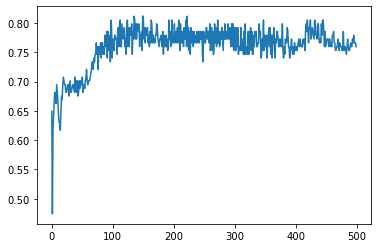

In [14]:
## Ignite the network and let it do the job

epochs = 500
final_losses = []
accuracy = []

for i in range(epochs):
    i += 1
    y_pred = model.forward(X_train)    
    loss = loss_function(y_pred, y_train)
    final_losses.append(loss)
    
    if i%10 == 1:
        print("Epoch no. {} and the loss is: {} ".format(i, loss.item()))
    
    ## Important step: we need to reduce the loss. So after epoch this line 
    # erases the gradient of all the optimized class
    optimizer.zero_grad()
    loss.backward() ## to backpropogate and findout the derivative
    optimizer.step()

    ## Model performance track: run a climbing hill
    predictions = []
    with torch.no_grad():
        for idx, data in enumerate(X_test):
            y_pred = model(data)
            predictions.append(y_pred.argmax().item())
    score = accuracy_score(y_test, predictions)
    accuracy.append(score)


plt.plot(range(epochs), accuracy)

In [15]:
print("Best accuracy: {} for iteration: {}".format(max(accuracy), np.asarray(accuracy).argmax()))

Best accuracy: 0.8116883116883117 for iteration: 135


Text(0.5, 0, 'Epoch')

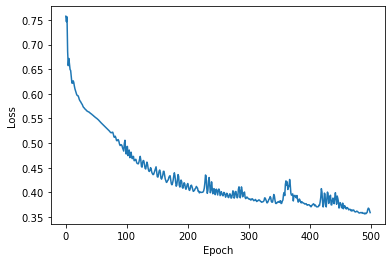

In [16]:
## Plot the loss function
plt.plot(range(epochs), final_losses)
plt.ylabel("Loss")
plt.xlabel("Epoch")

In [17]:
## Pickout the model 
predictions = []
with torch.no_grad():
    for i, data in enumerate(X_test):
        y_pred = model(data)
        predictions.append(y_pred.argmax().item())
print(predictions[:10])

[0, 1, 0, 0, 0, 0, 0, 1, 0, 0]


Model accuracy: 0.7597402597402597


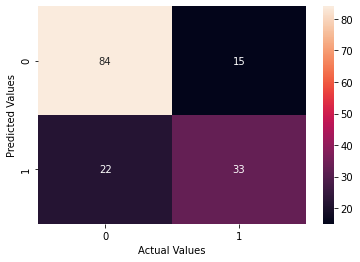

In [18]:
conf_mat = confusion_matrix(y_test, predictions)
sns.heatmap(conf_mat, annot=True)
plt.xlabel("Actual Values")
plt.ylabel("Predicted Values")

## Print accuracy and save the model
score = accuracy_score(y_test, predictions)
torch.save(model, "diabetes.pt")
print("Model accuracy: {}".format(score))